In [10]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import pandas as pd, numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [11]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
subm = pd.read_csv('data/sample_submission.csv')

In [24]:
train_data.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
none             0
dtype: int64

In [13]:
train_data.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [14]:
lens = train_data.comment_text.str.len()
lens.mean(), lens.std(), lens.max()
print(type(lens))

<class 'pandas.core.series.Series'>


Text(0, 0.5, 'number of comments')

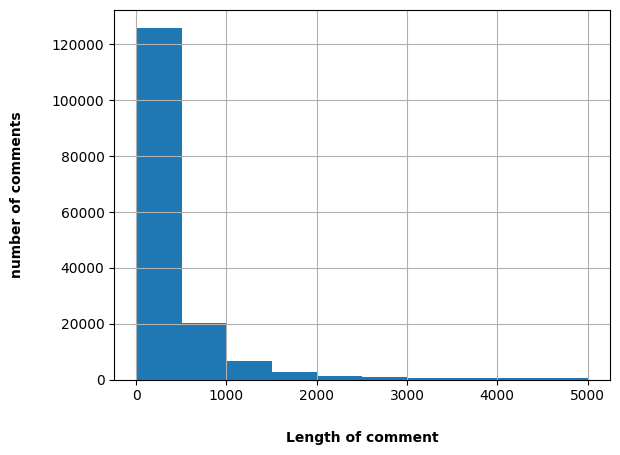

In [15]:
histogram = lens.hist();
histogram.set_xlabel("Length of comment", labelpad=20, weight='bold', size=10)
histogram.set_ylabel("number of comments", labelpad=20, weight='bold', size=10)

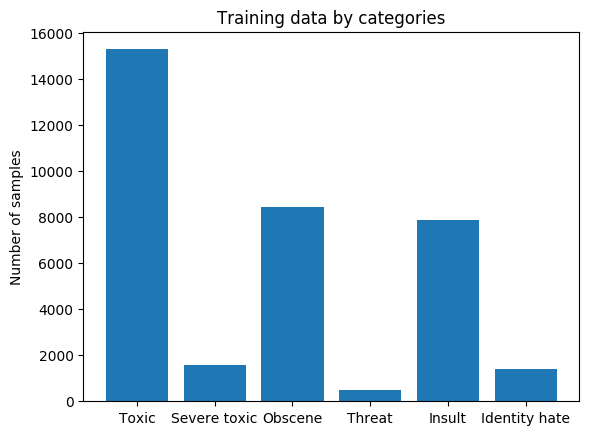

In [17]:
objects = ('Toxic', 'Severe toxic', 'Obscene', 'Threat', 'Insult', 'Identity hate')
y_pos = np.arange(len(objects))
performance = [15294, 1595, 8449, 478, 7877, 1405]

plt.bar(y_pos, performance, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Number of samples')
plt.title('Training data by categories')

plt.show()

In [18]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_data['none'] = 1 - train_data[label_cols].max(axis=1)
train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
len(train_data), len(test_data)

(159571, 153164)

In [20]:
train = train_data.copy()
test = test_data.copy()

In [21]:
COMMENT = 'comment_text'

In [33]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [23]:
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [34]:
vec

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=None,
                min_df=3, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words=None, strip_accents='unicode',
                sublinear_tf=1, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenize at 0x1256c77b8>, use_idf=1,
                vocabulary=None)

In [41]:
trn_term_doc, test_term_doc

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775119 stored elements in Compressed Sparse Row format>,
 <153164x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 14765768 stored elements in Compressed Sparse Row format>)

In [68]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    print(p, p.shape)
    return (p + 1) / ((y==y_i).sum() + 1)

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    print(type(x))
    x_nb = x.multiply(r)
    print('x.shape', x.shape, 'x_nb.shape', x_nb.shape, 'r.shape', r.shape)
    return m.fit(x_nb, y), r

In [74]:
x = trn_term_doc
test_x = test_term_doc
get_mdl(train['toxic']) 
print(train['toxic'])

[[438.24391835 296.09515903  20.77828104 ...   0.           0.
    0.        ]] (1, 426005)
[[1.28006902e+03 3.44151235e+02 1.64266203e+02 ... 2.37592243e-01
  3.05274626e+00 3.05274626e+00]] (1, 426005)
<class 'scipy.sparse.csr.csr_matrix'>
x.shape (159571, 426005) x_nb.shape (159571, 426005) r.shape (1, 426005)


ValueError: Solver lbfgs supports only dual=False, got dual=True

In [44]:
preds = np.zeros((len(test), len(label_cols)))

(153164, 6)


In [34]:
for i, j in enumerate(label_cols):
    print('fit', j)
    m, r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


fit severe_toxic


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit obscene


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit threat


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit insult


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit identity_hate


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [46]:
print(preds)
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
